# Simulating Edelweiss Data

The purpose of this notebook is to use the Edelweiss 2004 paper to extract a nuclear recoil Fano factor, and then use that in order to simulate data that should be comparable to the data presented in that paper. 

## Uncorrelated $E_I$ and $E_H$ with Truncated Expansion

First I start with the simplest case, where the $E_I$ and $E_H$ have uncorrelated gaussian errors and the expansion for the quenching random variable is assumed to truncate after the first two terms. 

\begin{equation}
\sigma_Q^2 = \left(\frac{dQ}{dE_I}\right)^2 \sigma_I^2 + \left(\frac{dQ}{dE_H}\right)^2 \sigma_H^2
\end{equation}

In this case if there is an "extra" Fano factor for nuclear recoils it would cause the $\sigma_Q$ to be larger, call it $\tilde{\sigma}_Q$. 

\begin{equation}
\tilde{\sigma}_Q^2 = \sigma_Q^2 + \left\{\frac{\epsilon}{E_R} \langle Q \rangle + \frac{2V}{E_R} \langle Q \rangle^2 + \frac{2V^2}{\epsilon E_R} \langle Q \rangle^2 \right\} F,
\end{equation}

where $F$ is the Fano factor for nuclear recoils. Further, the paper takes:

\begin{equation*}
  \langle Q \rangle = aE_R^b = 0.16E_R^{0.18},
\end{equation*}

and also acknowledges that the NR band needs to be wider; a fact they address by using a constant widening, $C$, so that:

\begin{equation}
\tilde{\sigma}_Q^2 = \sigma_Q^2 + C^2
\end{equation}

In [1]:
#let's create the F(Er,C;a,b) function
C = 0.035 #from Edw. paper
a = 0.16
b = 0.16
eps = 3.3 #eV
V = 4 #voltage in Volts

#take x in keV
F = lambda x: C**2/(((eps/1000)*a/(x**(1-b)))  + \
                   (2*(V/1000)*a**2/(x**(1-2*b))) + \
                   (2*(V/1000)**2*a**3/((eps/1000)*x**(1-3*b))) )

print(F(100))

import numpy as np
Fv = np.vectorize(F)

51.920586307776425


In [2]:
#set up a plot 
import matplotlib as mpl
from matplotlib import pyplot as plt
#got smarter about the mpl config: see mplstyles/ directory
plt.style.use('standard')

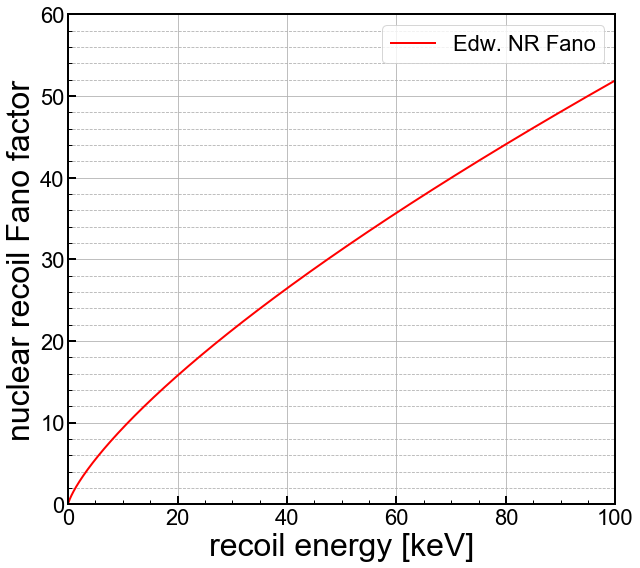

In [3]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes


X = np.arange(0.1,100,0.1)

ax1.plot(X,Fv(X),'r-',label='Edw. NR Fano')





#ax1.axvline(t(t_test[idx]), color='k', linestyle='-', lw=2, alpha=0.8,label=None)


ymin = 0
ymax = 60



ax1.set_yscale('linear')
#ax1.set_yscale('linear')
ax1.set_xlim(0, 100) 
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel(r'recoil energy [keV]',**axis_font)
ax1.set_ylabel('nuclear recoil Fano factor',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})
#ax1.legend(bbox_to_anchor=(1.04,1),borderaxespad=0,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
plt.savefig('figures/Edw_Fano_v1.png')
plt.show()

In [4]:
# now generate Edw. EI and EH values, then construct Q and ER

#first need the Edw. resolutions: taken from Amy's nrFano_Constraint/Edelweiss_data/Edelweiss_resolution_calculations.ipynb
sig0 = 0.4
sig122 = 3.5
aH = np.sqrt((sig122**2 - sig0**2)/122**2)
sigH = lambda x: np.sqrt(sig0**2 + (aH*x)**2)

print(sigH(10))

0.49114983912439203


In [5]:
#made a python library with the Edw Resolutions that Amy got
import EdwRes as edwres

heatRes_GGAl10 = edwres.get_heatRes_func(0.4, 3.5)
print(heatRes_GGAl10(122))
sigI_GGAl10 = edwres.get_ionRes_func(1.2, 1.3, 2.8)
print(sigI_GGAl10(10))

fhv = np.vectorize(heatRes_GGAl10)
fiv = np.vectorize(sigI_GGAl10)

3.4999999999999996
1.7781014366906955


In [6]:
#start generating stuff

N = 10000
V = 4
eps = 3.3 #eV per pair in Ge

Eer = np.random.uniform(0,200,N)
#Enr = np.random.uniform(0,200,np.uint32(N*0.3))
Enr = np.random.exponential(40,np.uint32(N*0.3)) #decrease by 1/e at 40 keV

print(np.shape(Eer))
print(Eer[0:10])

(10000,)
[ 37.91342028 169.24205176  16.90826135 190.19703136  17.83677482
 173.71555958  59.36285842  22.0953829  157.31314016 114.66803938]


In [7]:
Her = Eer 
Her = Her + np.random.normal(0.0,fhv(Her)/2.355,np.shape(Her))
Ier = Eer
Ier = Ier + np.random.normal(0.0,fiv(Ier)/2.355,np.shape(Ier))

Erer = (1+(V/eps))*Her - (V/eps)*Ier
Yer = Ier/Erer

#do the NRs
#create a yield model
import lindhard as lind

#lindhard
lpar = lind.getLindhardPars('Ge',True) #use the "calculated" value of k
ylind = lind.getLindhard(lpar)
ylindv = np.vectorize(ylind) #careful, this expects inputs in eV

yedw = lambda x: edwres.Q_avg(x)
yedwv = np.vectorize(yedw)

Hnr = (1 + (V/eps)*yedwv(Enr))*Enr/(1+(V/eps))
Hnr = Hnr + np.random.normal(0.0,fhv(Hnr)/2.355)
Inr = yedwv(Enr)*Enr
Inr = Inr + np.random.normal(0.0,fiv(Inr)/2.355)

Ernr = (1+(V/eps))*Hnr - (V/eps)*Inr
Ynr = Inr/Ernr

In [8]:
import pandas as pd
band_data = pd.read_csv("Edelweiss_data/edelweiss_bands_GGA1.csv")
print (band_data.head(10))

       x   Curve1   curve2   curve3   curve4
0  1.667 -6.44581 -0.08957  1.49300 -0.64478
1  1.802 -6.06069 -0.08789  1.44296 -0.62392
2  1.804 -6.05415 -0.08786  1.46798 -0.62356
3  1.938 -5.68168 -0.08613  1.41795 -0.60321
4  2.075 -5.31531 -0.08430  1.39293 -0.58303
5  2.212 -4.96139 -0.08240  1.36791 -0.56335
6  2.883 -3.39678 -0.07177  1.11174 -0.47381
7  3.158 -2.83384 -0.06656  1.10052 -0.44031
8  3.295 -2.57110 -0.06372  1.06171 -0.42438
9  4.518 -0.66571 -0.01776  0.75550 -0.30031


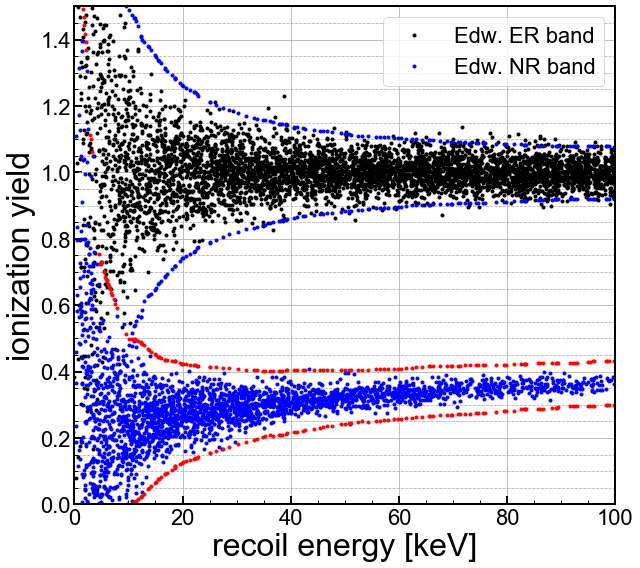

In [9]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes


X = np.arange(0.1,100,0.1)
ax1.plot(Erer,Yer,'o',color='k', label='Edw. ER band',linewidth=2,markersize=3)
ax1.plot(Ernr,Ynr,'o',color='b', label='Edw. NR band',linewidth=2,markersize=3)

# plot the data-theifed bands
ax1.plot(band_data.x[band_data.x>7.82], band_data.Curve1[band_data.x>7.82], 'b.',label='')
ax1.plot(band_data.x, band_data.curve2, 'b.',label='')
ax1.plot(band_data.x, band_data.curve3, 'r.',label='')
ax1.plot(band_data.x, band_data.curve4, 'r.',label='')

#ax1.plot(X,ynr_muv(X),'r--',label='NR mu')
#ax1.plot(X,ynr_muv(X)+3*ynr_sigv(X),'r-',label='NR 3$\sigma$')
#ax1.plot(X,ynr_muv(X)-3*ynr_sigv(X),'r-',label=None)

#ax1.plot(X,yer_muv(X),color='orange',linestyle='--',label='ER mu')
#ax1.plot(X,yer_muv(X)+3*yer_sigv(X),color='orange',linestyle='-',label='ER 3$\sigma$')
#ax1.plot(X,yer_muv(X)-3*yer_sigv(X),color='orange',linestyle='-',label=None)



#ax1.axvline(t(t_test[idx]), color='k', linestyle='-', lw=2, alpha=0.8,label=None)


ymin = 0
ymax = 1.5



ax1.set_yscale('linear')
#ax1.set_yscale('linear')
ax1.set_xlim(0, 100) 
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel(r'recoil energy [keV]',**axis_font)
ax1.set_ylabel('ionization yield',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})
#ax1.legend(bbox_to_anchor=(1.04,1),borderaxespad=0,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
plt.savefig('figures/yield_Edw_sim_F-ER.png')
plt.show()